In [6]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from tensorflow.math import confusion_matrix
import seaborn as sns
from sklearn import metrics
from WorkingPaper.python_model_antoine_ML.DL_logic.cleaning import final_cleaning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from pdfminer.high_level import extract_text
import joblib

In [2]:
data = pd.read_csv('../../raw_data/data_9k.csv')
data.head()

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,id,title,text,topic,subtopic
0,0,0.0,0.0,https://openalex.org/W2100716186,Large-scale screening of hypothetical metal-or...,PUBLISHED ONLINE: 6 NOVEMBER 2011 | DOI: 10.10...,Chemistry,Nanotechnology
1,1,1.0,1.0,https://openalex.org/W2109370530,Routing and wavelength assignment in all-optic...,"[H+./ACM TRANSACTIONS ON NETWORKING, VO1. 3, N...",Computer science,Telecommunications
2,2,2.0,2.0,https://openalex.org/W2131625303,Potassium channel antibody-associated encephal...,"DOI: 10.1093/brain/awh077 Brain (2004), 127, ...",Medicine,Pediatrics
3,3,3.0,3.0,https://openalex.org/W2131736388,"MODBASE, a database of annotated comparative p...","D336–D346 Nucleic Acids Research, 2014, Vol. 4...",Computer science,Bioinformatics
4,4,4.0,4.0,https://openalex.org/W2144966005,Regional brain volume abnormalities and long-t...,ORIGINAL CONTRIBUTION Regional Brain Volume A...,Medicine,Internal medicine


In [3]:
data['topic'].value_counts()

Biology                  3138
Medicine                 2064
Chemistry                 834
Psychology                657
Computer science          635
Physics                   321
Materials science         314
Mathematics               244
Environmental science     222
Economics                 176
Business                  109
Geology                    93
Geography                  84
Sociology                  48
Political science          37
Engineering                24
History                     6
Art                         4
Philosophy                  3
Name: topic, dtype: int64

In [7]:
# Reading data 2
data_2 = pd.read_csv('../../raw_data/data_21k.csv')
data_2.head()

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,id,title,text,topic,subtopic
0,0,0.0,0.0,0.0,0.0,0.0,https://openalex.org/W2100716186,Large-scale screening of hypothetical metal-or...,PUBLISHED ONLINE: 6 NOVEMBER 2011 | DOI: 10.10...,Chemistry,Nanotechnology
1,1,1.0,1.0,1.0,1.0,1.0,https://openalex.org/W2109370530,Routing and wavelength assignment in all-optic...,"[H+./ACM TRANSACTIONS ON NETWORKING, VO1. 3, N...",Computer science,Telecommunications
2,2,2.0,2.0,2.0,2.0,2.0,https://openalex.org/W2131625303,Potassium channel antibody-associated encephal...,"DOI: 10.1093/brain/awh077 Brain (2004), 127, ...",Medicine,Pediatrics
3,3,3.0,3.0,3.0,3.0,3.0,https://openalex.org/W2131736388,"MODBASE, a database of annotated comparative p...","D336–D346 Nucleic Acids Research, 2014, Vol. 4...",Computer science,Bioinformatics
4,4,4.0,4.0,4.0,4.0,4.0,https://openalex.org/W2144966005,Regional brain volume abnormalities and long-t...,ORIGINAL CONTRIBUTION Regional Brain Volume A...,Medicine,Internal medicine


In [8]:
data_2['topic'].value_counts()

Biology                  7528
Medicine                 4853
Chemistry                2189
Psychology               1553
Computer science         1403
Physics                   813
Materials science         796
Mathematics               521
Environmental science     463
Economics                 383
Business                  243
Geology                   234
Geography                 208
Sociology                 119
Political science          90
Engineering                62
History                    13
Art                         9
Philosophy                  8
Name: topic, dtype: int64

In [9]:
data_biology = data_2.loc[data_2['topic'] == 'Biology'][:4800]
data_medecine = data_2.loc[data_2['topic'] == 'Medicine'][:4800]

In [10]:
final_data = pd.concat([data_biology[['text','topic']],data_medecine[['topic']]])

In [12]:
data = final_data
data['topic'].value_counts()

Biology     4800
Medicine    4800
Name: topic, dtype: int64

In [14]:
data['text'] = data['text'].apply(lambda x: final_cleaning(str(x)))

In [15]:
data = data.dropna()

In [16]:
data['text'] = data['text'].apply(lambda x : ' '.join(x.split()[0:1000]))

In [17]:
data.head()

,text,topic
5,intact opensource open data molecular inter ac...,Biology
9,ded genomecshlporg september publish cold spri...,Biology
11,rnal neuroscience august behavioralsystemscogn...,Biology
15,crobiology ecology wwwfemsmicrobiologyorg mini...,Biology
20,tion immunotherapy melanoma use anti cytotoxic...,Biology


In [18]:
# OneHot Encoding topics
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
topic_targets_enc = pd.DataFrame(enc.fit_transform(data[['topic']]))
topic_targets_enc.columns = enc.get_feature_names_out()

In [19]:
data[['topic']].value_counts()

topic   
Biology     4800
Medicine    4800
dtype: int64

In [20]:
data.isnull().sum()

text     0
topic    0
dtype: int64

In [21]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data['text'], topic_targets_enc, test_size=0.3)

In [22]:
# N-gram 
count_vectorizer_n_gram = CountVectorizer(ngram_range = (2,2),min_df = 3,max_df=50)
count_vectorized_train = count_vectorizer_n_gram.fit_transform(X_train)
count_vectorized_test = count_vectorizer_n_gram.transform(X_test)

In [23]:
count_vectorized_train.toarray().shape

(6720, 364896)

In [24]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(count_vectorized_train,np.argmax(np.array(y_train), axis=1))
# predict the labels on validation dataset
predictions_SVM = SVM.predict(count_vectorized_test)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, np.argmax(np.array(y_test), axis=1))*100)

SVM Accuracy Score ->  96.97916666666667


Confusion matrix:
[[1342   87]
 [   0 1451]]


2022-09-08 10:40:43.521924: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0 topic_Biology
1 topic_Medicine


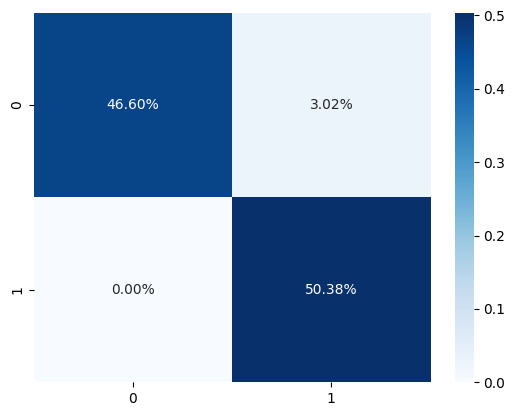

In [25]:
print("Confusion matrix:")
print(metrics.confusion_matrix(np.argmax(np.array(y_test), axis=1), predictions_SVM))

conf_matrix = confusion_matrix(labels=np.argmax(np.array(y_test), axis=1), predictions=predictions_SVM)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues')
for i, column in enumerate(topic_targets_enc.columns):
    print(i, column)

# Pipeline

In [50]:
preprocessor = CountVectorizer(max_df=100,max_features=30000,ngram_range=(2,2))
classifier_SVM = svm.SVC(gamma='auto', C=0.1, kernel='linear',probability=True)


pipeline_2 = Pipeline(steps=[("preprocesser", preprocessor), ("classifier_SVM", classifier_SVM)])
pipeline_2

Pipeline(steps=[('preprocesser',
                 CountVectorizer(max_df=100, max_features=30000,
                                 ngram_range=(2, 2))),
                ('classifier_SVM',
                 SVC(C=0.1, gamma='auto', kernel='linear', probability=True))])

In [51]:
pipeline_2.fit(X_train, np.argmax(np.array(y_train), axis=1))

Pipeline(steps=[('preprocesser',
                 CountVectorizer(max_df=100, max_features=30000,
                                 ngram_range=(2, 2))),
                ('classifier_SVM',
                 SVC(C=0.1, gamma='auto', kernel='linear', probability=True))])

In [52]:
pipeline_2.score

<bound method Pipeline.score of Pipeline(steps=[('preprocesser',
                 CountVectorizer(max_df=100, max_features=30000,
                                 ngram_range=(2, 2))),
                ('classifier_SVM',
                 SVC(C=0.1, gamma='auto', kernel='linear', probability=True))])>

In [53]:
prediction_pipe = pipeline_2.predict(X_test)

In [54]:
proba_predict = pipeline_2.predict_proba(X_test)

In [55]:
proba_predict

array([[4.57410000e-02, 9.54259000e-01],
       [4.57410000e-02, 9.54259000e-01],
       [4.57410000e-02, 9.54259000e-01],
       ...,
       [9.99999857e-01, 1.43086698e-07],
       [9.99999857e-01, 1.43318506e-07],
       [9.99999900e-01, 1.00000010e-07]])

In [56]:
accuracy_score(prediction_pipe, np.argmax(np.array(y_test), axis=1))

0.9697916666666667

Confusion matrix:
[[1342   87]
 [   0 1451]]
0 topic_Biology
1 topic_Medicine


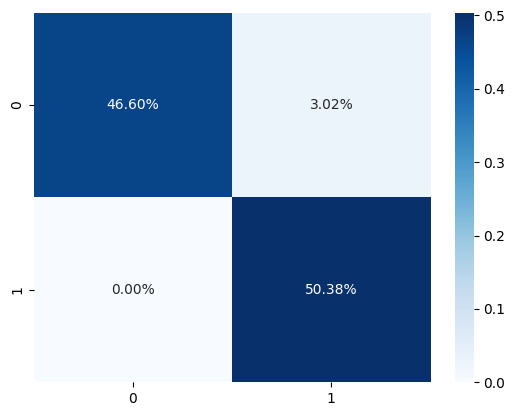

In [57]:
print("Confusion matrix:")
print(metrics.confusion_matrix(np.argmax(np.array(y_test), axis=1), prediction_pipe))

conf_matrix = confusion_matrix(labels=np.argmax(np.array(y_test), axis=1), predictions=prediction_pipe)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues')
for i, column in enumerate(topic_targets_enc.columns):
    print(i, column)

# saving the model

In [58]:
from tensorflow.keras import models
import joblib

def save_model_2(model = None):
    #model.save('WorkingPaper/local/ML_model_layer1.h5')
    path = '../local/ML_model_layer2.joblib'
    joblib.dump(model, path)
    return None

In [59]:
save_model_2(model = pipeline_2)

# evaluate

In [36]:
v1 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/biology_2.pdf')
v2 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/Biology_3.pdf')
v3 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/biology.pdf')
v4 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/math.pdf')
v5 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/physics.pdf')
v6 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/physics_2.pdf')
v7 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/medicine.pdf')
v8 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/medicine_2.pdf')
v9 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/medicine_paper_1.pdf')
v10 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/medicine_paper_2.pdf')
v11 = extract_text('/Users/antoinelemaire/code/Fito-22/WorkingPaper/raw_data/medicine_paper_3.pdf')


In [74]:
text = final_cleaning(v11)

In [50]:
pipeline_loaded_2 = joblib.load('../../WorkingPaper/local/ML_model_layer2.joblib')

In [75]:
text = ' '.join(text.split()[0:1000])
text_to_pred = np.array([text])

In [76]:
y_pred = pipeline_loaded_2.predict(text_to_pred)

In [77]:
print(y_pred)

[1]
